In [1]:
import numpy as np
import scipy.sparse as sp
import math
import matplotlib.pyplot as plt
from scipy.special import jn
from scipy.sparse import identity, csr_matrix, kron, diags, eye
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import MCXGate, MCPhaseGate, RXGate, CRXGate, QFTGate, StatePreparation, PauliEvolutionGate, RZGate
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator, Pauli
from scipy.linalg import expm
from qiskit.qasm3 import dumps  # QASM 3 exporter
from qiskit.qasm3 import loads
from qiskit.circuit.library import QFT
from qiskit.primitives import StatevectorEstimator
from qiskit import transpile
from square_hole_grid import *
from generate_fdtd_matrix_zeroed import *

## Problem Setup (Additional Details with PEC body)

In addition to the governing equations, discretization, and matrix formulation for the 2D Maxwell system are exactly as described in the accompanying document *“FDTD Equations”* (shared separately).

The computational domain includes an **internal perfectly electric conducting (PEC) obstacle**:

- The overall computational domain is a **square grid**.
- A **square PEC body** is located at the center of the grid, aligned with the grid axes.
- All field degrees of freedom inside the body are set to zero.
- On the boundary of the internal square body, **PEC boundary conditions** are enforced (i.e., the tangential electric field \( E_z = 0 \)).
- Finite-difference stencils adjacent to the body are modified consistently to respect the internal PEC boundary.

To generate the correponding A matrix for such a problem, we provide the code that generates the A matrix for the setup as below.

In [103]:
nx = 16
ny = 16
L = nx-1
hole_center_x = nx//2
hole_center_y = ny//2
hole_size = 6

AE_mat, AH_mat = generate_fdtd_matrices(nx,ny, L, hole_center=(hole_center_x, hole_center_y), hole_size=hole_size, eps_r=1.0)

A_hole = AE_AH_to_A(AE_mat, AH_mat)
print(A_hole.shape)

(736, 736)


## Visualizing the grid
The following cell describes the meshing of the grid, where no grid points correspond to a body. 

Hole bounds: {'xL': 5.0, 'xR': 11.0, 'yB': 5.0, 'yT': 11.0}
Kept points: 231 / 256
Inner edge node counts: {'left': 7, 'right': 7, 'bottom': 7, 'top': 7}


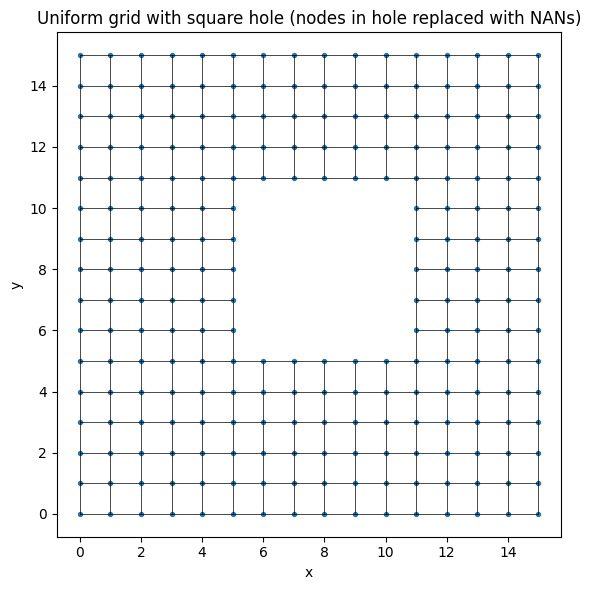

In [104]:
X_holed, Y_holed, keep_mask, XY_kept, hole_bounds, inner_nodes, outer_nodes = (
    square_grid_with_square_hole_points(
        N_outer=nx,
        L=L,
        hole_center=(hole_center_x, hole_center_y),
        hole_size=hole_size,
        align="snap",
        include_outer_boundary=True,
    )
)

print("Hole bounds:", hole_bounds)
print("Kept points:", XY_kept.shape[0], "/", X_holed.size)
print("Inner edge node counts:",
        {k: v["ij"].shape[0] for k, v in inner_nodes.items()})

# --- Plot holed-out grid ---
plt.figure(figsize=(6,6))

# Draw gridlines: loop over rows & cols, skip nan segments automatically
for i in range(X_holed.shape[0]):  # horizontal lines
    plt.plot(X_holed[i, :], Y_holed[i, :], linewidth=0.5, color='k')
for j in range(X_holed.shape[1]):  # vertical lines
    plt.plot(X_holed[:, j], Y_holed[:, j], linewidth=0.5, color='k')

# print(X_holed,Y_holed)
plt.scatter(X_holed, Y_holed, s=8)
plt.gca().set_aspect('equal')
plt.title("Uniform grid with square hole (nodes in hole replaced with NANs)")
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout()
plt.show()

## Source Term
Furthermore in addition to the grid with a body we also add a source term so that the equation looks like $$du/dt = Au + j_E(t)$$, where $$j_E(t) = \vec{j_0}j(t) = \vec{j_0}sin(\omega t)$$. Since j(t) is a solution of $\partial^2/\partial dt ^2 = -\omega^2 j(t)$. This second order equation is reduced to first order by introducing $k(t) = \partial j(t)/\partial t$. So that the total scheme is as following 

$$
\partial/\partial t \begin{bmatrix} Ez \\ Hx \\ Hy \\ j \\k\end{bmatrix} =
\begin{bmatrix}
0 & AE  & \vec{j_0} & 0\\
AH  & 0 & 0 &  0 \\
0 & 0 & 0 & 1  \\
0 & 0 &-\omega^2 & 0
\end{bmatrix} \begin{bmatrix} Ez \\ Hx \\ Hy \\ j \\k\end{bmatrix}
$$

We choose the $\vec{j_0}$ as some delta that has a non-zero value in the Ez space, such that it is a vector as described below. $\omega$ can be choosen as some frequency between $[0, 2 \pi]$.

In [105]:
impulse_pos = (L//4, 3*L//4)
omega =  np.pi / 4

dx = dy = 1
x_delta = int(round(impulse_pos[0] / dx))
y_delta = int(round(impulse_pos[1] / dy))

# delta_source in the subspace of Ez
delta_source = np.zeros((A_hole.shape[0], 1))
delta_source[nx*y_delta + x_delta, 0] = 1

zero_col = np.zeros((A_hole.shape[0], 1))
zero_row = np.zeros((1, A_hole.shape[1]))

A = np.block([
    [A_hole,   delta_source, zero_col],
    [zero_row, np.array([[0]]), np.array([[1]])],
    [zero_row, np.array([[-omega**2]]), np.array([[0]])]
])

### Evolution 

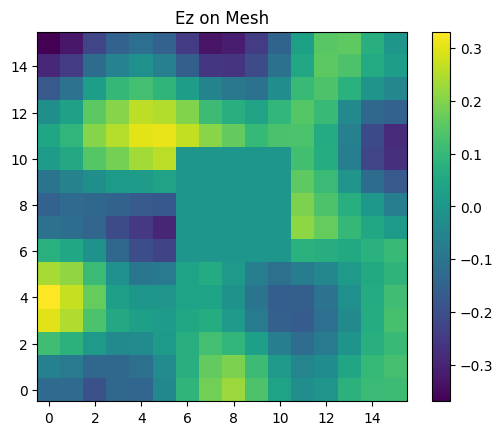

In [ ]:
initial_state = np.zeros((A_hole.shape[0]+2))

initial_state[-1] = omega # set k = omega

T = 50
expAt = expm(A * T)
EzHxHy = np.matmul(expAt,  initial_state)

plt.imshow(EzHxHy[:AE_mat.shape[0]].reshape(nx,nx), cmap="viridis", origin="lower")

plt.colorbar()
plt.title("Ez on Mesh")
plt.show()